# Enhanced Pancreas Cell Analysis with scGPT

This notebook provides a comprehensive analysis of pancreatic cell data using scGPT embeddings.
We'll perform:
- Data loading and validation
- Embedding analysis
- Dimensionality reduction
- Batch effect analysis
- Machine learning model comparison

## 1. Setup and Imports

In [1]:
# Import required libraries
from pathlib import Path
import warnings
import scanpy as sc
import scib 
import numpy as np
import pandas as pd
import sys 
import scgpt as scg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import umap

# Set plotting style
plt.style.context('default')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\umap\__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [12]:
def setup_directories():
    """Set up necessary directories and paths"""
    repo_dir = Path.cwd().parent.absolute()
    data_dir = repo_dir / "data"
    save_dir = repo_dir / "save"
    
    # Create directories if they don't exist
    data_dir.mkdir(parents=True, exist_ok=True)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    return repo_dir, data_dir, save_dir

# Set up configuration
config = {
    "file_path": "  h5ad",
    "n_top_genes": 1800,
    "gene_col": "gene_name",
    "cell_type_key": "celltype",
    "batch_key": "tech",
    "normalize_total": 1e4,
    "binning": 10,
    "use_hvg": True
}

# Set up directories
repo_dir, data_dir, save_dir = setup_directories()
print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Save directory: {save_dir}")

Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Data directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data
Save directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\save


## 2. Data Loading and Initial Processing

In [2]:
# Define file paths and parameters
hvg_file = Path("C:/Users/annel/OneDrive/Documenten/Machine Learning/scGPT/save/adata_hvg.h5ad")
embed_file = Path("C:/Users/annel/OneDrive/Documenten/Machine Learning/scGPT/data/human_pancreas_norm_complexBatch_embedded.h5ad")

# Load HVG data
if hvg_file.exists():
    print(f"Loading existing HVG AnnData file from {hvg_file}")
    adata = sc.read_h5ad(hvg_file)
    print(f"Loaded AnnData with shape: {adata.shape}")
else:
    print("No existing HVG AnnData file found")

# Set up parameters
gene_col = "gene_name"
cell_type_key = "celltype"
batch_key = "tech"
N_HVG = 1800

Loading existing HVG AnnData file from C:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\save\adata_hvg.h5ad
Loaded AnnData with shape: (16382, 1800)


## 3. Load and Analyze Embeddings

In [3]:
# Load embedded data
adata_embed = sc.read_h5ad(embed_file)
print("\nEmbedded data information:")
print(adata_embed)

# Create dataframe from embeddings
embeddings_df = pd.DataFrame(adata_embed.obsm["X_scGPT"])
print("\nFirst few rows of scGPT embeddings:")
print(embeddings_df.head())

# Basic statistics
print("\nEmbedding Statistics:")
print(embeddings_df.describe())


Embedded data information:
AnnData object with n_obs × n_vars = 16382 × 1722
    obs: 'tech', 'celltype', 'size_factors'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'id_in_vocab'
    uns: 'hvg', 'log1p'
    obsm: 'X_scGPT'
    layers: 'counts'

First few rows of scGPT embeddings:
        0         1         2         3         4         5         6    \
0  0.073707  0.003733  0.012353  0.045787  0.028686 -0.056230 -0.011507   
1  0.071376 -0.001319  0.009428  0.041126  0.030103 -0.045669 -0.007892   
2  0.071767 -0.001087  0.003495  0.024505  0.013971 -0.056813 -0.007876   
3  0.068650 -0.009042  0.010772  0.032528  0.003143 -0.059393 -0.001724   
4  0.050278 -0.014192  0.012542  0.025254  0.020374 -0.052632  0.018501   

        7         8         9    ...       502       503       504       505  \
0 -0.010013  0.009184 -0.000568  ...  0.008169  0.018345 -0.009001 -0.054426   
1 -0.011339  0.009670 -0.014000  ... -0.006212

In [17]:
repo_dir = Path.cwd().parent.absolute()
sys.path.append(str(repo_dir))

from src.utils import setup_data_dir
setup_data_dir()
data_dir = repo_dir / "data"

# Set up of the model directory 
model_dir = repo_dir / "scGPT_data" / "scGPT_CP"

print(f"Repository directory: {repo_dir}")
print(f"Model directory: {model_dir}")

from my_src.my_utils import check_annotation_keys

Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Model directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\scGPT_data\scGPT_CP


In [18]:
keys = check_annotation_keys(adata)


Checking cell type annotations in .obs:

✓ Found 'celltype' with 14 unique values
Examples:
  1. gamma
  2. acinar
  3. alpha
  4. delta
  5. beta
Top counts:
  alpha: 5493 cells
  beta: 4169 cells
  ductal: 2142 cells
  acinar: 1669 cells
  delta: 1055 cells

Checking gene annotations in .var:

✓ Found 'gene_name' with 1800 unique values
Examples:
  1. A2M
  2. A4GALT
  3. AADAC
  4. AADACL2
  5. AADACL3

Checking highly variable gene annotations in .var:

✓ Found 'highly_variable' (boolean) with 1800/1800 genes marked as highly variable
Percentage: 100.00%

✓ Found 'highly_variable_rank' with 1800 unique values
Examples:
  1. 1747.0
  2. 1741.0
  3. 862.0
  4. 603.0
  5. 863.0

Checking additional metadata:
Available .uns keys: ['hvg', 'log1p']
Available .layers: ['counts']


## 4. Create Train/Test Split

In [4]:
# Create reference and query datasets
mask = np.random.rand(len(adata_embed)) < 0.8

# Create a column indicating whether each cell is from reference or query set
adata_embed.obs["is_ref"] = ["Reference" if m else "Query" for m in mask]
adata_embed.obs["is_ref"] = adata_embed.obs["is_ref"].astype("category")

# Split the data
adata_ref = adata_embed[mask].copy()
adata_query = adata_embed[~mask].copy()

print(f"Reference dataset shape: {adata_ref.shape}")
print(f"Query dataset shape: {adata_query.shape}")

Reference dataset shape: (13110, 1722)
Query dataset shape: (3272, 1722)


## 5. Visualization with UMAP

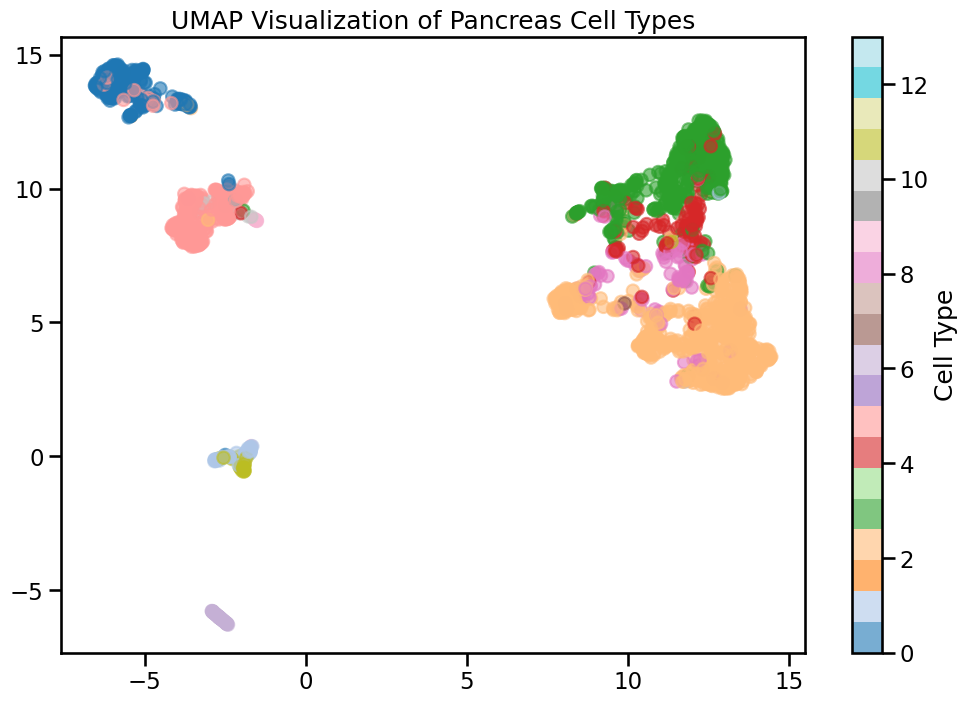

In [5]:
# Prepare UMAP visualization
reducer = umap.UMAP(random_state=42)
random_indices = np.random.choice(adata_embed.shape[0], size=2000, replace=False)
umap_embeddings = reducer.fit_transform(adata_embed.obsm["X_scGPT"][random_indices])

# Create UMAP plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                     c=adata_embed.obs.celltype.cat.codes[random_indices],
                     cmap='tab20', alpha=0.6)
plt.title("UMAP Visualization of Pancreas Cell Types")
plt.colorbar(scatter, label="Cell Type")
plt.show()

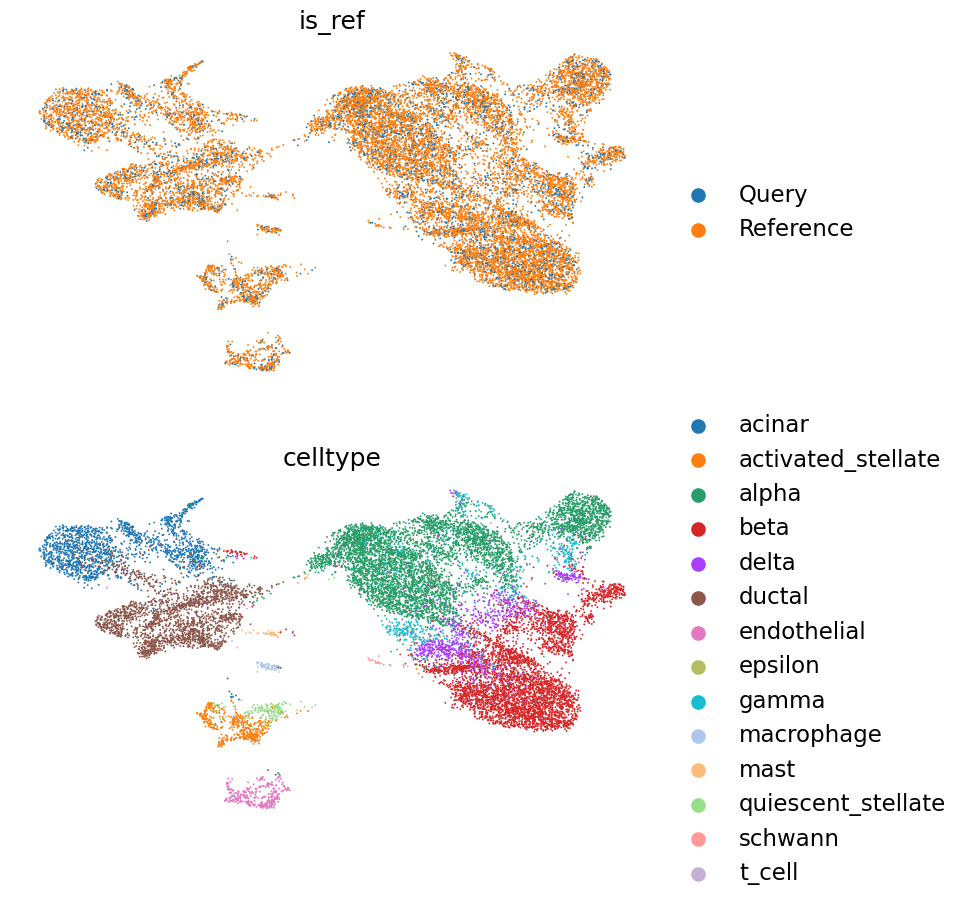

In [19]:
sc.pp.neighbors(adata_embed, use_rep="X_scGPT")
sc.tl.umap(adata_embed)
sc.pl.umap(
    adata_embed, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

## 6. Batch Effect Analysis

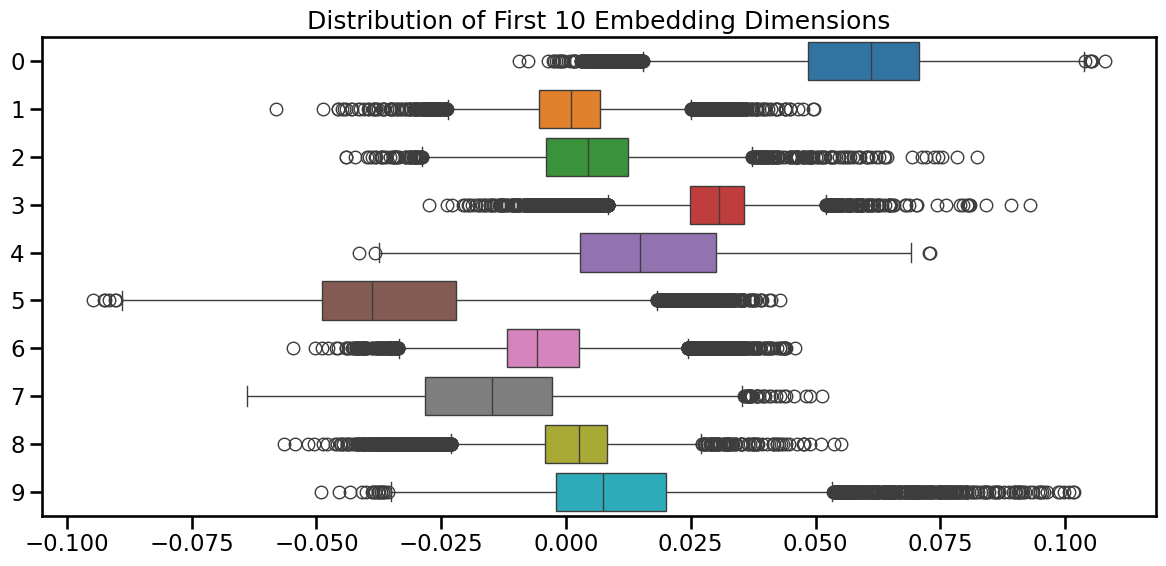


Batch distribution across cell types:
celltype    acinar  activated_stellate  alpha  beta  delta  ductal  \
tech                                                                 
celseq         228                  19    191   161     50     327   
celseq2        274                  90    843   445    203     258   
fluidigmc1      21                  16    239   258     25      36   
inDrop1        110                  51    236   872    214     120   
inDrop2          3                  81    676   371    125     301   
inDrop3        843                 100   1130   787    161     376   
inDrop4          2                  52    284   495    101     280   
smarter          0                   0    886   472     49       0   
smartseq2      188                  55   1008   308    127     444   

celltype    endothelial  epsilon  gamma  macrophage  mast  quiescent_stellate  \
tech                                                                            
celseq                5     

In [6]:
# Visualize batch effects
plt.figure(figsize=(12, 6))
sns.boxplot(data=embeddings_df.iloc[:, :10], orient="h")
plt.title("Distribution of First 10 Embedding Dimensions")
plt.tight_layout()
plt.show()

# Create batch effect summary
batch_summary = pd.crosstab(adata_embed.obs[batch_key], 
                           adata_embed.obs[cell_type_key])
print("\nBatch distribution across cell types:")
print(batch_summary)

## 7. Machine Learning Model Comparison

In [7]:
# Prepare data for modeling
X = pd.DataFrame(adata_embed.obsm["X_scGPT"])
y = adata_embed.obs[cell_type_key]

# Create train/test split considering batch effects
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=adata_embed.obs[batch_key]))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Train and evaluate models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced")
}

results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'model': name,
        'macro_avg_f1': report['macro avg']['f1-score'],
        'weighted_avg_f1': report['weighted avg']['f1-score']
    })
    
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Show final results
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
print(results_df)


Training KNN...

KNN Classification Report:
                    precision    recall  f1-score   support

            acinar       0.98      0.87      0.92      1117
activated_stellate       0.82      0.95      0.88       190
             alpha       0.94      0.98      0.96      2859
              beta       0.94      0.94      0.94      1704
             delta       0.69      0.67      0.68       413
            ductal       0.79      0.97      0.87       634
       endothelial       1.00      0.95      0.97       113
           epsilon       0.00      0.00      0.00         6
             gamma       0.75      0.36      0.49       231
        macrophage       0.93      0.90      0.91        29
              mast       0.85      0.85      0.85        13
quiescent_stellate       0.91      0.48      0.63        66
           schwann       1.00      0.80      0.89         5
            t_cell       1.00      0.50      0.67         2

          accuracy                           0.91    

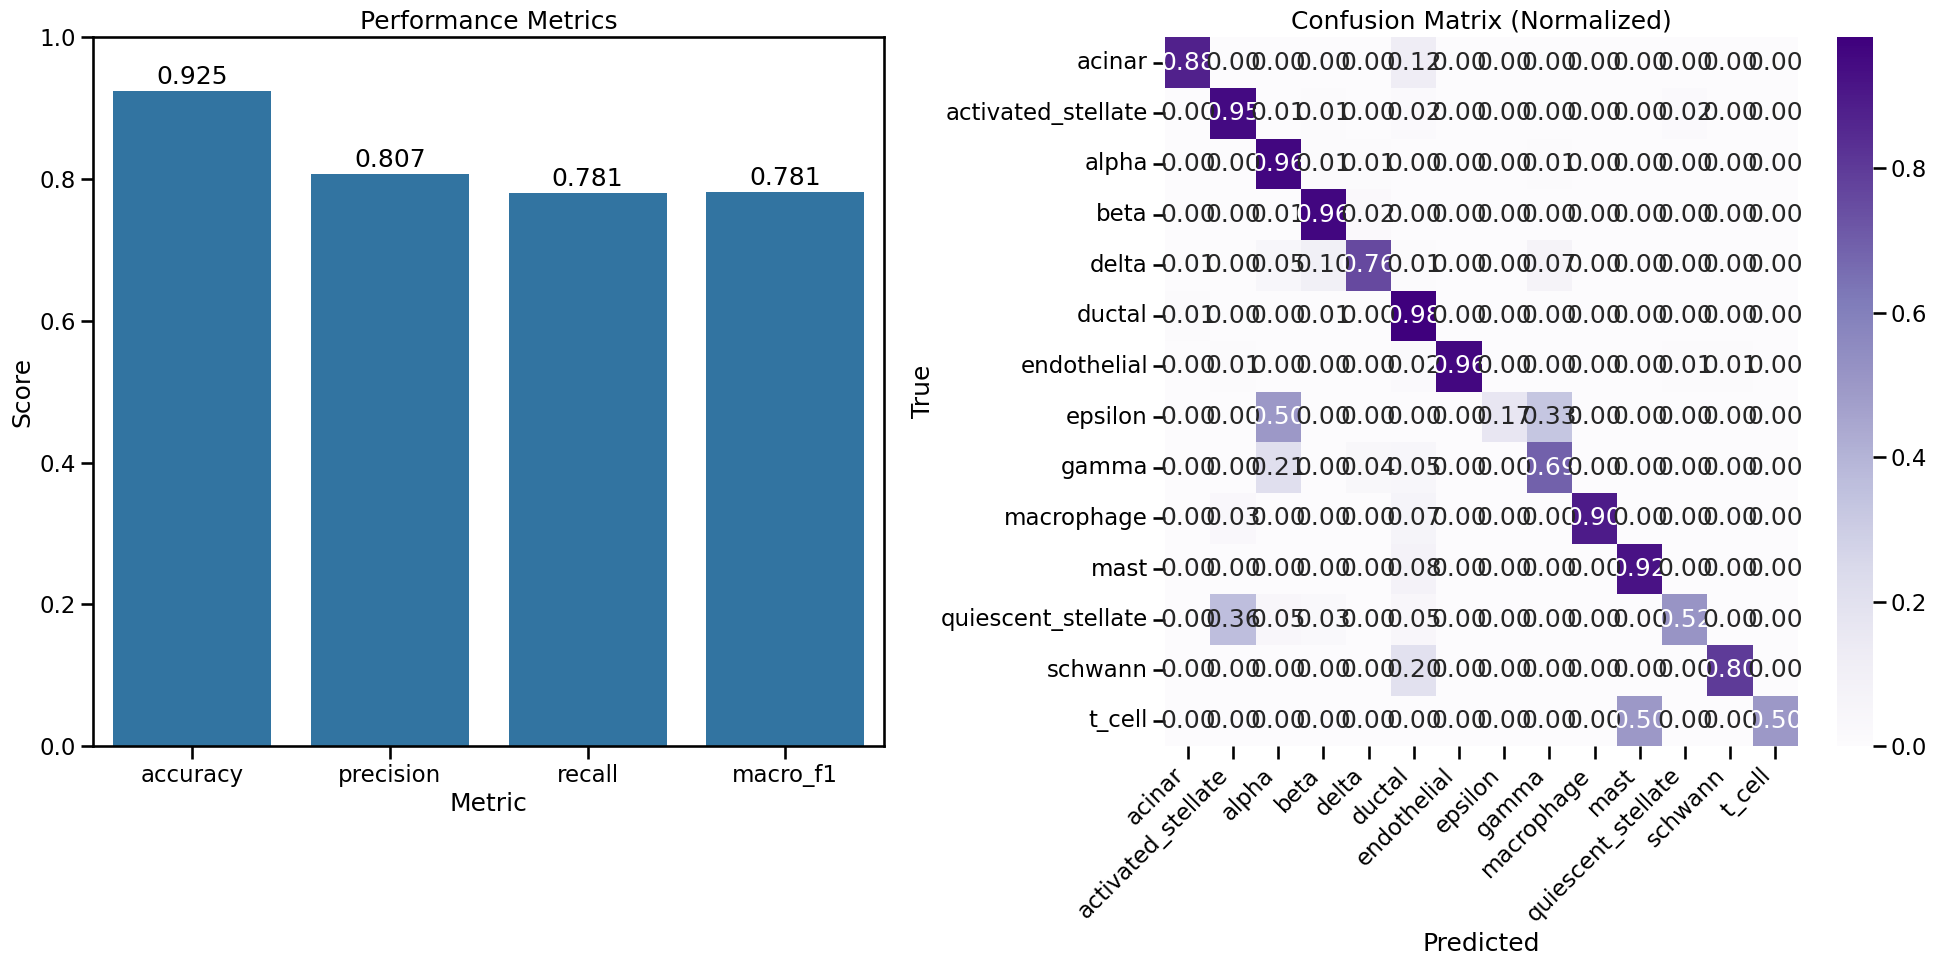


Detailed Performance Metrics:
accuracy: 0.925
precision: 0.807
recall: 0.781
macro_f1: 0.781


In [ ]:
# Calculate performance metrics for the best model (LightGBM)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Use the predictions from LightGBM (best performing model)
best_model = models["LightGBM"] # but can use another one 
y_pred = best_model.predict(X_test)
gt = y_test  # ground truth
preds = y_pred

res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

fig = plt.figure(figsize=(20, 10))

# Left subplot for metrics
ax1 = plt.subplot(121)
metrics_df = pd.DataFrame(list(res_dict.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=metrics_df, ax=ax1)
ax1.set_title('Performance Metrics')
ax1.set_ylim(0, 1)  # Set y-axis from 0 to 1
for i, v in enumerate(metrics_df['Score']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')  # Add value labels

# Right subplot for confusion matrix
ax2 = plt.subplot(122)
cell_type_list = np.unique(gt)
matrix = confusion_matrix(gt, preds, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

# Create confusion matrix heatmap
df = pd.DataFrame(matrix, 
                 index=cell_type_list[:matrix.shape[0]], 
                 columns=cell_type_list[:matrix.shape[1]])
sns.heatmap(df, 
            cmap='Purples',
            annot=True,
            fmt=".2f",
            cbar=True,
            ax=ax2)

ax2.set_title('Confusion Matrix (Normalized)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Performance Metrics:")
for metric, value in res_dict.items():
    print(f"{metric}: {value:.3f}")

## 8. Save Results and Embeddings

In [8]:
# Save the processed data
adata_embed.write_h5ad("pancreas_analysis_results.h5ad")
results_df.to_csv("model_comparison_results.csv")

print("Analysis complete! Results have been saved.")

Analysis complete! Results have been saved.
